In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
from sklearn.model_selection import train_test_split
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from random import randint
from keras.preprocessing.text import one_hot
import os
import pandas as pd
import re

Using TensorFlow backend.


In [2]:
from stop_words import get_stop_words


In [327]:
epochs = 50
batchSize = 8

max_len_text=200 
max_len_summary=20
checkpoint = "weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
dataset = "dataset/articles.csv"

In [143]:

#df = pd.read_json("dataset.json", encoding='utf-8')
df = pd.read_csv(dataset, encoding='utf-8')

print(df.shape)
print(df.head())
print(df.isnull().sum())

(20346, 6)
                                              titulo  \
0  Lula diz que está 'lascado', mas que ainda tem...   
1  'Decidi ser escrava das mulheres que sofrem', ...   
2  Três reportagens da Folha ganham Prêmio Petrob...   
3  Filme 'Star Wars: Os Últimos Jedi' ganha trail...   
4  CBSS inicia acordos com fintechs e quer 30% do...   

                                               texto        data  categoria  \
0  Com a possibilidade de uma condenação impedir ...  2017-09-10      poder   
1  Para Oumou Sangaré, cantora e ativista malines...  2017-09-10  ilustrada   
2  Três reportagens da Folha foram vencedoras do ...  2017-09-10      poder   
3  A Disney divulgou na noite desta segunda-feira...  2017-09-10  ilustrada   
4  O CBSS, banco da holding Elopar dos sócios Bra...  2017-09-10    mercado   

  subcategoria                                               link  
0          NaN  http://www1.folha.uol.com.br/poder/2017/10/192...  
1          NaN  http://www1.folha.uol.com

In [144]:
df = df.dropna()

In [384]:
df.describe()

,titulo,texto,data,categoria,subcategoria,link,cleaned_text,cleaned_summary
count,4107,4107,4107,4107,4107,4107,4107,4107
unique,4065,4095,150,7,179,4107,4095,4065
top,Aviso,O colunista está em férias.,2017-08-27,colunas,monicabergamo,http://www1.folha.uol.com.br/colunas/luiz-hort...,o colunista está em férias,_START_ aviso _END_
freq,36,5,89,3484,516,1,5,36


In [146]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that wo uld", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [385]:
df['titulo'][:10].tolist()

['\n\t\tDa escola ao 1º emprego: como buscar um caminho profissional sem ter (ao menos ainda) um diploma universitário\n\t\t',
 '50 anos depois da morte, o Che é apenas uma foto na camiseta',
 'Afinal, nosso voto tem preço?',
 'Cientista dá psicodélico para minicérebros, e eles gostam',
 'Reestruturação da Sabesp deverá ser levada à Justiça por setor de limpeza',
 'Em série sobre Revolução Russa, Mika Lins lê teses famosas de Lênin',
 'Preservar passado é um dos grandes desafios dos processos de revitalização',
 'Não à Copa sem Lionel Messi',
 'UNE processa Lollapalooza por suspeita de burlar lei da meia entrada',
 "Esquerda pode tomar democratas, que vivem 'cabo-de-guerra', diz 'NYT'"]

In [387]:
df['texto'][:3].tolist()

['DA BBC BRASIL  O trimestre de maio a julho deste ano foi encerrado com um índice de desemprego na casa de 12,8%.  O percentual assusta, mas é menor do que os 13,7% apurados no fim do período imediatamente anterior. Os dados mostram um quadro preocupante, mas que sugere que o pior da crise pode já ter ficado para trás.  Só que a situação dos trabalhadores entre 18 e 24 anos é mais complicada do que a da média.  Segundo a mesma pesquisa do IBGE, nada menos do que 28,8% dos jovens nessa faixa etária estavam desocupados ao fim do primeiro trimestre de 2017. Esse percentual recorde equivale a 4,503 milhões de pessoas.  Os trabalhadores mais novos sempre sofrem mais com as crises e o desemprego decorrente.  Por um lado, eles representam custos menores (e menos produtividade perdida) para as empresas na hora da demissão.  De outro, a menor experiência no mercado dificulta a busca por oportunidades.  Mas é fato também que os empregos que exigem menor qualificação costumam ser os primeiros a 

In [149]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
            text = " ".join(new_text)
            text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
            text = re.sub(r'\<a href', ' ', text)
            text = re.sub(r'&amp;', '', text)
            text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
            text = re.sub(r'<br />', ' ', text)
            text = re.sub(r'\'', ' ', text)
            #if remove_stopwords:
            #    text = text.split()
            #    text = [w for w in text if not w in get_stop_words('portuguese')]
            #    print(text)
            #text = " ".join(text)
    return text

In [150]:

cleaned_text = []
for t in df['texto']:
    cleaned_text.append(clean_text(t))

In [151]:

cleaned_summary = []
for t in df['titulo']:
    cleaned_summary.append(clean_text(t))


In [388]:
cleaned_summary[:10]

['da escola ao 1º emprego  como buscar um caminho profissional sem ter  ao menos ainda  um diploma universitário',
 '50 anos depois da morte  o che é apenas uma foto na camiseta',
 'afinal  nosso voto tem preço ',
 'cientista dá psicodélico para minicérebros  e eles gostam',
 'reestruturação da sabesp deverá ser levada à justiça por setor de limpeza',
 'em série sobre revolução russa  mika lins lê teses famosas de lênin',
 'preservar passado é um dos grandes desafios dos processos de revitalização',
 'não à copa sem lionel messi',
 'une processa lollapalooza por suspeita de burlar lei da meia entrada',
 'esquerda pode tomar democratas  que vivem  cabo de guerra   diz  nyt ']

In [153]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [392]:
df.iloc[0:5]

,titulo,texto,data,categoria,subcategoria,link,cleaned_text,cleaned_summary
43,\n\t\tDa escola ao 1º emprego: como buscar um ...,DA BBC BRASIL O trimestre de maio a julho des...,2017-09-10,sobretudo,carreiras,http://www1.folha.uol.com.br/sobretudo/carreir...,da bbc brasil o trimestre de maio a julho dest...,_START_ da escola ao 1º emprego como buscar u...
46,"50 anos depois da morte, o Che é apenas uma fo...","Ernesto Rafael Guevara de La Serna, o homem, m...",2017-09-10,colunas,clovisrossi,http://www1.folha.uol.com.br/colunas/clovisros...,ernesto rafael guevara de la serna o homem m...,_START_ 50 anos depois da morte o che é apena...
59,"Afinal, nosso voto tem preço?",A reforma política aprovada pelo Congresso dei...,2017-09-10,colunas,joao-amoedo,http://www1.folha.uol.com.br/colunas/joao-amoe...,a reforma política aprovada pelo congresso dei...,_START_ afinal nosso voto tem preço _END_
62,"Cientista dá psicodélico para minicérebros, e ...",A batalha de jovens neurocientistas para reabi...,2017-09-10,colunas,marceloleite,http://www1.folha.uol.com.br/colunas/marcelole...,a batalha de jovens neurocientistas para reabi...,_START_ cientista dá psicodélico para minicére...
63,Reestruturação da Sabesp deverá ser levada à J...,Associações de empresas de limpeza urbana e re...,2017-09-10,colunas,mercadoaberto,http://www1.folha.uol.com.br/colunas/mercadoab...,associações de empresas de limpeza urbana e re...,_START_ reestruturação da sabesp deverá ser le...


In [160]:
for i in range(2):
    print("Review:",df['cleaned_text'].iloc[i])
    print("Summary:",df['cleaned_summary'].iloc[i])
    print("\n")

Review: da bbc brasil o trimestre de maio a julho deste ano foi encerrado com um índice de desemprego na casa de 12 8   o percentual assusta  mas é menor do que os 13 7  apurados no fim do período imediatamente anterior  os dados mostram um quadro preocupante  mas que sugere que o pior da crise pode já ter ficado para trás  só que a situação dos trabalhadores entre 18 e 24 anos é mais complicada do que a da média  segundo a mesma pesquisa do ibge  nada menos do que 28 8  dos jovens nessa faixa etária estavam desocupados ao fim do primeiro trimestre de 2017  esse percentual recorde equivale a 4 503 milhões de pessoas  os trabalhadores mais novos sempre sofrem mais com as crises e o desemprego decorrente  por um lado  eles representam custos menores  e menos produtividade perdida  para as empresas na hora da demissão  de outro  a menor experiência no mercado dificulta a busca por oportunidades  mas é fato também que os empregos que exigem menor qualificação costumam ser os primeiros a su

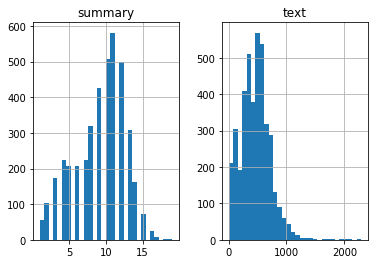

In [161]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [163]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.2,random_state=0,shuffle=True) 


In [164]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [165]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [166]:
x_tr.shape,y_tr.shape

((3285, 200), (3285, 20))

In [167]:
x_val.shape, y_val.shape

((822, 200), (822, 20))

In [168]:
x_voc_size, y_voc_size

(66740, 7721)

In [169]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [170]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 


In [171]:
#Attention Layer
attn_layer = AttentionLayer(name='attention_weight') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

W1111 15:14:33.352613 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.
W1111 15:14:33.464610 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.


In [172]:


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 500)     33370000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [173]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [174]:
if os.path.isfile(checkpoint):
    model.load_weights(checkpoint)

In [175]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [176]:
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
    epochs=epochs,
    callbacks=[es, mc],
    batch_size=batchSize,
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
)

Train on 3285 samples, validate on 822 samples
Epoch 1/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.7627
Epoch 00001: loss improved from inf to 3.76129, saving model to weights-improvement-01-3.7613-bigger.hdf5
3285/3285 [==============================] - 968s 295ms/sample - loss: 3.7613 - val_loss: 2.8325
Epoch 2/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.4879
Epoch 00002: loss improved from 3.76129 to 3.48664, saving model to weights-improvement-02-3.4866-bigger.hdf5
3285/3285 [==============================] - 945s 288ms/sample - loss: 3.4866 - val_loss: 2.8479
Epoch 3/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.3735
Epoch 00003: loss improved from 3.48664 to 3.37185, saving model to weights-improvement-03-3.3719-bigger.hdf5
3285/3285 [==============================] - 951s 289ms/sample - loss: 3.3719 - val_loss: 2.8019
Epoch 4/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.2745
Epoch 00004: loss im

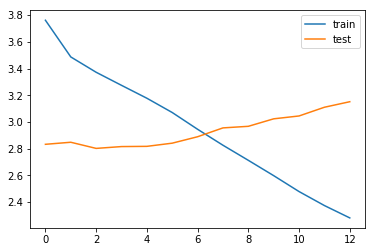

In [177]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [178]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [179]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

W1111 18:42:23.314169 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.


W1111 18:42:23.790719 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.


In [180]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        if sampled_token_index == 0:
            return decoded_sentence
            
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [181]:
def seq2summary(input_seq):
    newString=''
    #print(target_word_index)
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

In [182]:

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [380]:
#print(reverse_target_word_index)
for i in range(10):
  print("Review:",seq2text(x_val[i]))
  print("\n")
  print("\tOriginal summary:",seq2summary(y_val[i]))
  print("\tPredicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: 1982 o milan foi parar na série b por envolvimento de seus jogadores e dirigentes no esquema das apostas na loteria esportiva em 2005 até o goleiro gianluigi buffon admitiu que participava de apostas num caso paralelo de manipulação escalas de arbitragem a juventus foi rebaixada não é só no brasil não é só no futebol não é só com bicheiros há apostas em jogos de tênis da nfl da nba do futebol inglês na itália no rio em são paulo com carimbo oficial dos governos com anúncio de sites em emissoras de televisão a cbf acaba de contratar uma empresa especializada em apostas ilegais para tentar vigiar e evitar que se repitam escândalos como os do passado todo mundo é inocente até que prove o contrário e se houver erro de algum árbitro um frango de um goleiro gol perdido por atacante não pense que foi porque quis errar eu vou lhe avisar goleiro não pode falhar mas muita gente vai comemorar se o zagueiro do seu time entregar o ouro e deixar alguém na cara do gol para acertar os pontos n

	Predicted summary:  o que é ser um esquerda


Review: palavras –mas suas implicações como os de ontem o general tem direito a suas próprias opiniões com a condição de que seja transferido à reserva por que villas bôas limita se a uma advertência protocolar e mesmo ela sob pressão do ministro da defesa o mistério remete aos movimentos ainda desconexos que escapam às telas dos radares numa ponta a crise da lava jato provocada pelo desastroso acordo do mp de janot com os irmãos batista semeia dúvidas sobre o futuro do combate judicial à corrupção sistêmica na outra a corrente periférica de golpistas civis procura estabelecer uma cabeça de ponte nos quarteis por meio da candidatura de jair bolsonaro que se apressou em compartilhar a palestra de mourão villas bôas identificou uma ofensiva em pinça –e equivocadamente preferiu recuar até uma trincheira defensiva o primeiro mourão operava para getúlio vargas em 1937 e para o núcleo golpista do alto comando em 1964 o segundo por ora apenas rep

In [393]:

model.load_weights('weights/weights-improvement-07-2.9450-bigger.hdf5')

In [382]:
x_val.shape

(822, 200)

In [394]:
#print(reverse_target_word_index)
for i in range(10):
  print("Review:",seq2text(x_val[i]))
  print("\tOriginal summary:",seq2summary(y_val[i]))
  print("\tPredicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: 1982 o milan foi parar na série b por envolvimento de seus jogadores e dirigentes no esquema das apostas na loteria esportiva em 2005 até o goleiro gianluigi buffon admitiu que participava de apostas num caso paralelo de manipulação escalas de arbitragem a juventus foi rebaixada não é só no brasil não é só no futebol não é só com bicheiros há apostas em jogos de tênis da nfl da nba do futebol inglês na itália no rio em são paulo com carimbo oficial dos governos com anúncio de sites em emissoras de televisão a cbf acaba de contratar uma empresa especializada em apostas ilegais para tentar vigiar e evitar que se repitam escândalos como os do passado todo mundo é inocente até que prove o contrário e se houver erro de algum árbitro um frango de um goleiro gol perdido por atacante não pense que foi porque quis errar eu vou lhe avisar goleiro não pode falhar mas muita gente vai comemorar se o zagueiro do seu time entregar o ouro e deixar alguém na cara do gol para acertar os pontos n

	Predicted summary:  o que é o que não é o que não é de um país


Review: palavras –mas suas implicações como os de ontem o general tem direito a suas próprias opiniões com a condição de que seja transferido à reserva por que villas bôas limita se a uma advertência protocolar e mesmo ela sob pressão do ministro da defesa o mistério remete aos movimentos ainda desconexos que escapam às telas dos radares numa ponta a crise da lava jato provocada pelo desastroso acordo do mp de janot com os irmãos batista semeia dúvidas sobre o futuro do combate judicial à corrupção sistêmica na outra a corrente periférica de golpistas civis procura estabelecer uma cabeça de ponte nos quarteis por meio da candidatura de jair bolsonaro que se apressou em compartilhar a palestra de mourão villas bôas identificou uma ofensiva em pinça –e equivocadamente preferiu recuar até uma trincheira defensiva o primeiro mourão operava para getúlio vargas em 1937 e para o núcleo golpista do alto comando em 1964 o segundo

In [373]:
teste = '''
Na avaliação destes militares, a continuar neste ritmo, Bolsonaro acabará forçando os colegas das Forças Armadas a repensarem se vale a pena seguir em seus cargos no governo. Pois, se permanecerem, é como se os militares dessem aval às polêmicas e confusões criadas pelo presidente da República.
'''


In [374]:
teste = clean_text(teste)

In [375]:
testeVetorizado = x_tokenizer.texts_to_sequences([teste])

In [376]:
testeVetorizado = pad_sequences(testeVetorizado,  maxlen=max_len_text, padding='post') 

In [377]:
for item in testeVetorizado:
    print("Review:",seq2text(item))

Review: na avaliação destes militares a continuar neste ritmo bolsonaro acabará forçando os colegas das forças armadas a se vale a pena seguir em seus cargos no governo pois se permanecerem é como se os militares dessem aval às polêmicas e confusões criadas pelo presidente da república 


In [378]:
print("\tPredicted summary:",decode_sequence(testeVetorizado.reshape(1,max_len_text)))


	Predicted summary:  o que é o que não é o que não é de um ele tem
